In [2]:
import pandas as pd
import numpy as np

from plotnine import *

import statsmodels.formula.api as smf

from pandas_profiling import ProfileReport

import warnings

warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("../data/cps-earnings/clean/morg-2014-emp.csv",index_col = 0)

 Selecting:
 - Computer programmers 1010
 - Software developers, applications and systems software 1020
 - Web developers 1030

In [4]:
work = data.loc[lambda x: x["occ2012"].isin([1010,1020,1030])]

Dropping household id and month of questionary, (also the weight ?)

In [5]:
work = work.drop(["hhid","intmonth"],axis=1)

In [6]:
work.isnull().sum()

stfips         0
weight         0
earnwke        0
uhours         0
grade92        0
race           0
ethnic      1977
age            0
sex            0
marital        0
ownchild       0
chldpres       0
prcitshp       0
state          0
ind02          0
occ2012        0
class          0
unionmme       0
unioncov      55
lfsr94         0
dtype: int64

# 1. Feature engineering

## Target variable

In [7]:
work["w"] = work["earnwke"] / work["uhours"]
work["lnw"] = np.log(work["w"])

## Continous variables

In [8]:
work["edu"] = work["grade92"]
work["agesq"] = np.power(work["age"], 2)

## Categorical variables

### 1. race

In [9]:
work.race.value_counts()

1     1443
4      487
2       97
8       16
3        8
5        6
7        5
6        2
11       1
13       1
17       1
Name: race, dtype: int64

I decode race based on pdf as: 1:"white" 2:"black" 4:"asian" else:"other"

In [10]:
work["race"] = np.where(
    work["race"] == 1,
    "white",
    np.where(
        work["race"] == 2,
        "black",
        np.where(work["race"] == 4, "asian", "other"),
    ),
)

### 2. gender

In [11]:
work["sex"] = work.sex.map({1:"male",2:"female"})

### 3. marital

In [12]:
work.marital.value_counts().sort_index()

1    1306
2       4
3      35
4      13
5     133
6      24
7     552
Name: marital, dtype: int64

In [13]:
work["marital_status"] = np.where(
    work["marital"].isin([1, 2, 3]),
    "married",
    np.where(work["marital"].isin([4, 5, 6]), "used to be married", "never married"),
)

### 4. union

In [14]:
work["union"] = ((work["unionmme"] == "Yes") | (work["unioncov"] == "Yes")).astype(int)

### 5. children

In [15]:
work.ownchild.value_counts().sort_index()

0    1236
1     344
2     367
3      97
4      14
5       4
6       3
7       1
9       1
Name: ownchild, dtype: int64

In [16]:
work["n_children"] = np.where(work["ownchild"]>=3,"3>=",work["ownchild"].astype("str"))

### 6. employment status

In [17]:
work["emp_status"] = work.lfsr94

work.emp_status.value_counts()

Employed-At Work    2023
Employed-Absent       44
Name: emp_status, dtype: int64

### 7. class

In [18]:
work["class"].value_counts()

Private, For Profit     1796
Private, Nonprofit        92
Government - Federal      81
Government - State        74
Government - Local        24
Name: class, dtype: int64

### 8. occupation

In [19]:
work["occup"] = work["occ2012"]
work["occup"].value_counts()

1020    1335
1010     516
1030     216
Name: occup, dtype: int64

### 9. industry

In [20]:
work["industry"] = work["ind02"]

work["industry"] = np.where(
    work["industry"] == "Computer systems design and related services (5415)",
    "Computer systems design",
    "Other",
)

work["industry"].value_counts()

Other                      1340
Computer systems design     727
Name: industry, dtype: int64

### 10. state

Lof of states, probably won't use it.

In [21]:
work["state"] = work["stfips"]

### 11. non-USborn

In [22]:
work.prcitshp.value_counts()

Native, Born In US                        1445
Foreign Born, Not a US Citizen             323
Foreign Born, US Cit By Naturalization     263
Native, Born Abroad Of US Parent(s)         29
Native, Born in PR or US Outlying Area       7
Name: prcitshp, dtype: int64

In [23]:
work["nonUSborn"] = (
    (work["prcitshp"] == "Foreign Born, US Cit By Naturalization")
    | (work["prcitshp"] == "Foreign Born, Not a US Citizen")
).astype(int)

In [24]:
work = work.filter(
    [
        "w",
        "lnw",
        "age",
        "agesq",
        "sex",
        "race",
        "edu",
        "marital_status",
        "n_children",
        "union",
        "emp_status",
        "class",
        "occup",
        "industry",
        "nonUSborn",
    ]
)

# 2. Descriptive statistics

In [25]:
profile = ProfileReport(work, title="CPS-earnings", explorative=True)

profile.to_file("cps_report.html")

<AxesSubplot:>

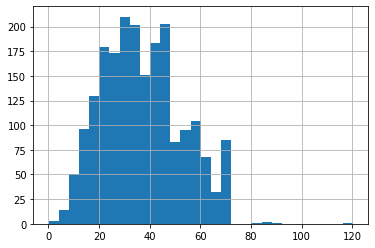

In [26]:
work.w.hist(bins=30)